In [1]:
# Libraries
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
import matplotlib.animation as animation
%matplotlib inline
from IPython.display import HTML

# Extend PATH Variable
import sys
sys.path.append("src/")

# NanoNets Simulation Tool
import nanonets

# Plot Colors
blue_color  = '#348ABD'
red_color   = '#A60628'

Init disordered Network Topology and Electrostatic Properties:
- Number of nanopartciles $N_{NP}$ and number of junctions per $N_{J}$
- Electrode Positions as list of cartesian coordinates `[[x_1, y_1], [x_2, y_2], [x_3, y_3], ...]` \
Network is placed inside box of size 1 with electrodes attached to closest nanoparticle

In [34]:
# Network Style
network_topology = "cubic"

# Network Parameter
# topology_parameter  = {
#     "Np"    : 25,
#     "Nj"    : 4,
#     "e_pos" : [[-1,-1],[1,1]]
# }
topology_parameter  = {
    "Nx"    : 7,
    "Ny"    : 7,
    "Nz"    : 1,
    "e_pos" : [[0,0,0],[3,0,0],[0,3,0],[6,0,0],[0,6,0],[6,3,0],[3,6,0],[6,6,0]]
}

# Save Folder
folder  = "test_runs/"

# Topology Class
np_network_sim = nanonets.simulation(network_topology=network_topology, folder=folder, topology_parameter=topology_parameter)

In [3]:
# R_vals              = np.abs(np.random.normal(25*np_network_sim.ele_charge*np_network_sim.ele_charge*1e-12, 5*np_network_sim.ele_charge*np_network_sim.ele_charge*1e-12, size=len(np_network_sim.adv_index_rows)))
# connection_array    = np.zeros((np_network_sim.N_particles+np_network_sim.N_electrodes,np_network_sim.N_particles+np_network_sim.N_electrodes))

# for i in range(len(np_network_sim.adv_index_rows)):

#     connection_array[np_network_sim.adv_index_rows[i], np_network_sim.adv_index_cols[i]] = R_vals[i]

# norm_val = np.max(np.abs(np.linalg.eigvals(connection_array)))

Display Network Topology

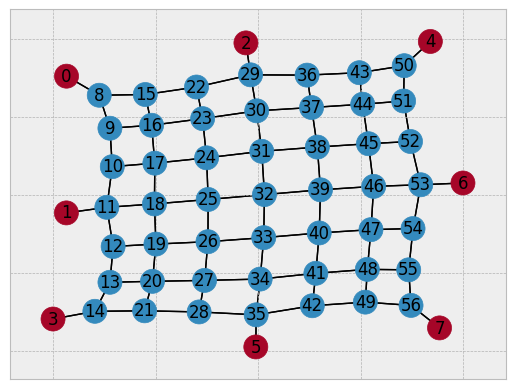

In [51]:
# Return Graph Object
G   = np_network_sim.return_graph_object()
# pos = nx.spectral_layout(G)

# Node Positions
# fixed_pos                               = {i : val for i, val in enumerate(topology_parameter["e_pos"])}
# pos                                     = nx.spring_layout(G=G, pos=fixed_pos, fixed=[i for i in range(np_network_sim.N_electrodes)])
# pos_vals                                = np.array(list(dict(sorted(pos.items())).values()))
# pos_vals_e                              = pos_vals[np_network_sim.N_electrodes:]
# pos_vals_e                              = 1.6*(pos_vals_e - np.min(pos_vals_e,axis=0))/(np.max(pos_vals_e,axis=0) - np.min(pos_vals_e,axis=0)) - 0.8
# pos_vals[np_network_sim.N_electrodes:]  = pos_vals_e

# for i in range(np_network_sim.N_particles):
#     pos[i] = pos_vals[i,:]

# Node Colors
colors                                  = np.repeat('#348ABD', np_network_sim.N_particles+np_network_sim.N_electrodes)
colors[:np_network_sim.N_electrodes]    = '#A60628'

# Display Graph
with plt.style.context(["bmh"]):

    fig = plt.figure()
    ax  = fig.add_subplot()
    nx.draw_networkx(G=G,  ax=ax, node_color=colors, arrows=False)
    plt.show()

Input Voltages

Number of Steps: 100000


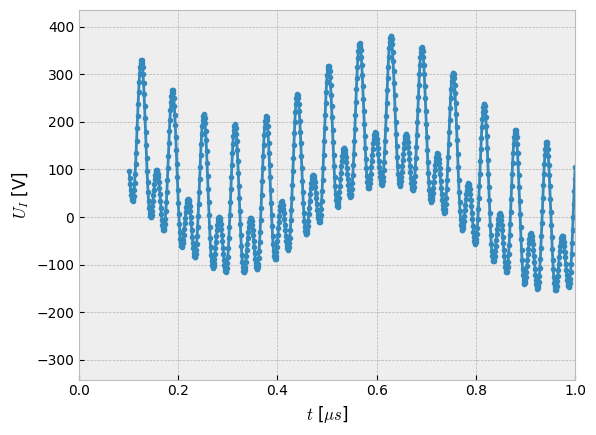

In [5]:
# Define Time Scale
start_val   = 100
step_size   = 1e-9
max_time    = 1e-4
time_steps  = np.arange(0,max_time,step_size)
N_steps     = len(time_steps)
time        = time_steps[start_val+1:]*10**6

print(f"Number of Steps: {N_steps}")

# Define Peak
t_min_peak      = 10e-6
t_max_peak      = 13e-6
peak_bounds     = (time_steps >= t_min_peak) & (time_steps <= t_max_peak)


# Input Voltages
input_volt                  = 0.1*(np.cos(200*time_steps*1e6) + np.cos(100*time_steps*1e6) + np.cos(10*time_steps*1e6) + np.cos(1*time_steps*1e6))
# input_volt                  = np.repeat(0.1,N_steps)
# input_volt[peak_bounds]     = 0.2
inputs                      = 1000*input_volt[start_val+1:]

# Voltage Array
N_electrodes    = np_network_sim.N_electrodes
voltages        = np.zeros((N_steps, N_electrodes+1))
voltages        = np.zeros((N_steps, N_electrodes+1))
voltages[:,0]   = input_volt
# voltages[:,1]   = np.repeat(-0.1, N_steps)
# voltages[:,2]   = np.repeat(0.3, N_steps)

# Plot
with plt.style.context("bmh"):
    
    plt.plot(time, inputs, '.-')
    plt.xlabel("$t$ [$\mu s$]")
    plt.ylabel("$U_I$ [V]")
    plt.xlim(0,1)
    plt.show()

In [6]:
def run_simulation(voltages, time_steps, target_electrode, network_topology, topology_parameter, R, Rstd, store_per_it_min, store_per_it_max, folder="", n_stat=10, save_th=.1, start_val=100):

    output_vals     = []
    microstate      = []
    landscape       = []
    net_currents    = []
    network_classes = []
    
    for _ in range(n_stat):
    
        np_network_sim = nanonets.simulation(network_topology=network_topology, folder=folder, topology_parameter=topology_parameter)
        np_network_sim.run_var_voltages(voltages=voltages, time_steps=time_steps, target_electrode=target_electrode, save_th=save_th,
                                        store_per_it_min=store_per_it_min, store_per_it_max=store_per_it_max, R=R, Rstd=Rstd)
        
        # Return Output Current
        output_df               = pd.DataFrame(np_network_sim.return_output_values()).iloc[start_val:,1:3].reset_index(drop=True)
        output_df.columns       = ["Jumps","Current"]
        output_df["Current"]    = output_df["Current"]/1000

        # Return Microstate
        microstate_df   = pd.DataFrame(np_network_sim.return_microstates()).iloc[start_val:,:].reset_index(drop=True)

        # Return Landscape
        landscape_df    = pd.DataFrame(np_network_sim.return_potential_landscape()).iloc[start_val:,np_network_sim.N_electrodes:].reset_index(drop=True)

        # Return Network Currents
        jump_paths, network_I   = np_network_sim.return_network_currents()
        network_I_df            = pd.DataFrame(network_I)
        network_I_df.columns    = jump_paths
        network_I_df            = network_I_df.iloc[start_val:].reset_index(drop=True)

        # Append Results
        output_vals.append(output_df)
        microstate.append(microstate_df)
        landscape.append(landscape_df)
        net_currents.append(network_I_df)
        network_classes.append(np_network_sim)

    outputs = {
        "output"            : output_vals,
        "microstate"        : microstate,
        "landscape"         : landscape,
        "net_currents"      : net_currents,
        "network_classes"   : network_classes
    }

    return outputs

In [7]:
store_per_it_min    = 12e-6
store_per_it_max    = 14e-6
simulation_outputs  = run_simulation(voltages=voltages, time_steps=time_steps, target_electrode=N_electrodes-1,
                    network_topology=network_topology, topology_parameter=topology_parameter,
                    R=25.0, Rstd=5.0, store_per_it_min=store_per_it_min, store_per_it_max=store_per_it_max, start_val=start_val)

In [8]:
output_values               = pd.concat([pd.DataFrame(np.mean(simulation_outputs['output'],axis=0)),pd.DataFrame(np.std(simulation_outputs['output'],axis=0))/np.sqrt(len(simulation_outputs['output']))],axis=1)
output_values.columns       = ["Jumps","Current","Jumps_Error","Current_Error"] 
microstate                  = pd.DataFrame(np.mean(simulation_outputs["microstate"],axis=0))
microstate_error            = pd.DataFrame(np.std(simulation_outputs["microstate"],axis=0))/np.sqrt(len(simulation_outputs["microstate"]))
landscape                   = 1000*pd.DataFrame(np.mean(simulation_outputs["landscape"],axis=0))
landscape_error             = 1000*pd.DataFrame(np.std(simulation_outputs["landscape"],axis=0))/np.sqrt(len(simulation_outputs["landscape"]))
net_currents                = pd.DataFrame(np.mean(simulation_outputs["net_currents"],axis=0))
net_currents.columns        = simulation_outputs["net_currents"][0].columns
net_currents_error          = pd.DataFrame(np.std(simulation_outputs["net_currents"],axis=0))/np.sqrt(len(simulation_outputs["net_currents"]))
net_currents_error.columns  = simulation_outputs["net_currents"][0].columns

In [9]:
print(f"Average Jumps per Step: {np.round(output_values['Jumps'].mean(),2)}")

Average Jumps per Step: 38.21


### Output electric Current

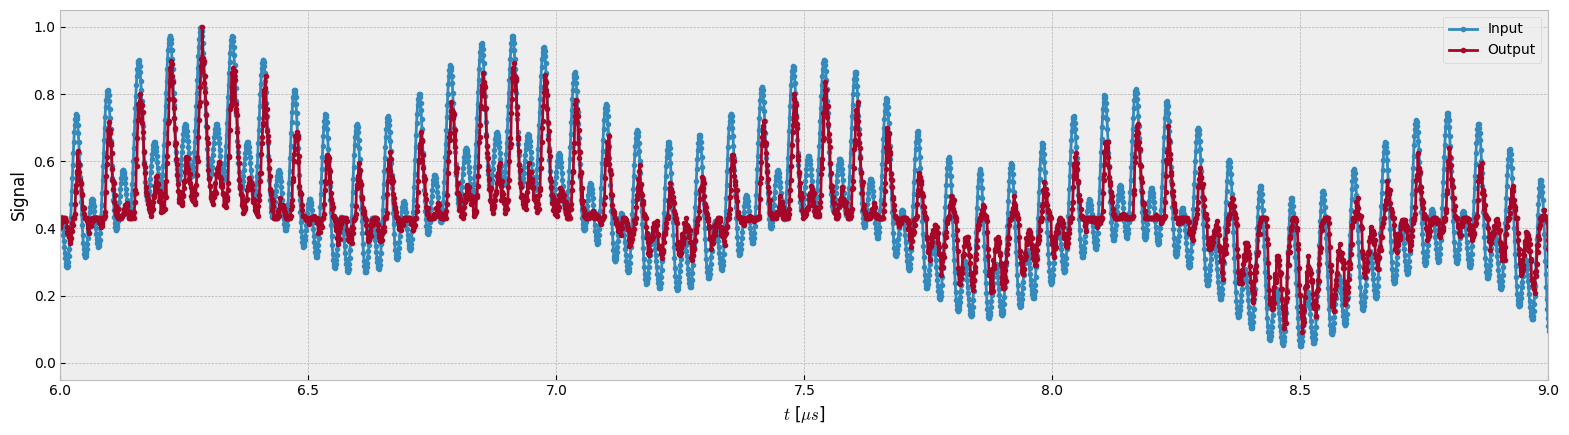

In [10]:
normed_input    = (inputs - np.min(inputs))/(np.max(inputs)-np.min(inputs))
normed_output   = (output_values['Current'] - np.min(output_values['Current']))/(np.max(output_values['Current'])-np.min(output_values['Current']))

with plt.style.context("bmh"):

    fig = plt.figure()
    fig.set_figwidth(fig.get_figwidth()*3)
    fig.set_figheight(fig.get_figheight())
    ax  = fig.add_subplot()
    ax.plot(time, normed_input, '.-', label="Input")
    ax.plot(time, normed_output, '.-', label="Output")
    # ax.fill_between(x=time, y1=(output_values['Current']-output_values['Current_Error']), y2=(output_values['Current']+output_values['Current_Error']), alpha=0.8)
    # ax.plot(time, inputs, '.-', label="Input")
    ax.set_xlabel("$t$ [$\mu s$]")
    ax.set_ylabel("Signal")
    ax.legend()
    ax.set_xlim(6,9)
    
plt.show()

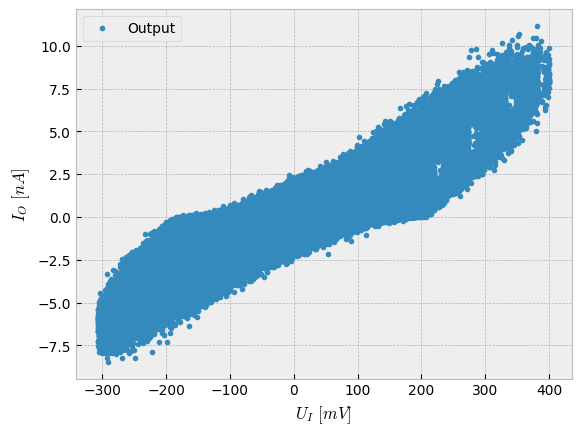

In [11]:
with plt.style.context("bmh"):

    fig = plt.figure()
    ax  = fig.add_subplot()
    ax.plot(inputs, output_values['Current'], '.', label="Output")
    # ax.plot(time, inputs, '.-', label="Input")
    ax.set_xlabel("$U_{I}$ $[mV]$")
    ax.set_ylabel("$I_O$ $[nA]$")
    ax.legend()


In [12]:
plt.rcParams["animation.html"] = "jshtml"
from IPython.display import HTML

In [21]:
output_values['Current']

0        2.214626
1        1.662930
2        1.327985
3        0.851101
4        1.092451
           ...   
99894    1.242040
99895    1.222593
99896    1.115048
99897    1.222163
99898    1.547790
Name: Current, Length: 99899, dtype: float64

MovieWriter ffmpeg unavailable; using Pillow instead.


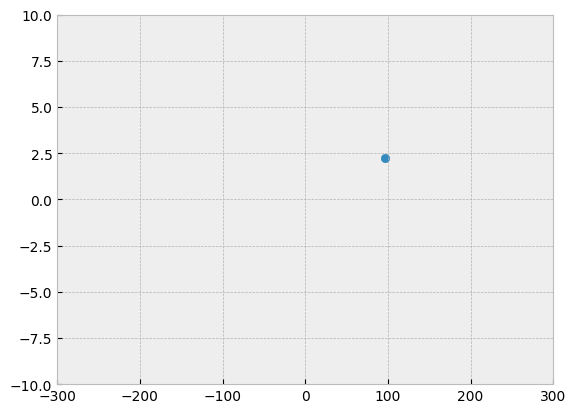

In [22]:
with plt.style.context("bmh"):

    fig, ax = plt.subplots()
    ax.set_xlim(-300,300)
    ax.set_ylim(-10,10)

    scat = ax.scatter(inputs[0],output_values['Current'][0])

    def animate(i):
        scat.set_offsets((inputs[i],output_values['Current'][i]))
        return scat,

    ani = animation.FuncAnimation(fig, animate, repeat=True,
                                        frames=1000, interval=1)

ani.save("test.gif")

#### Micro State

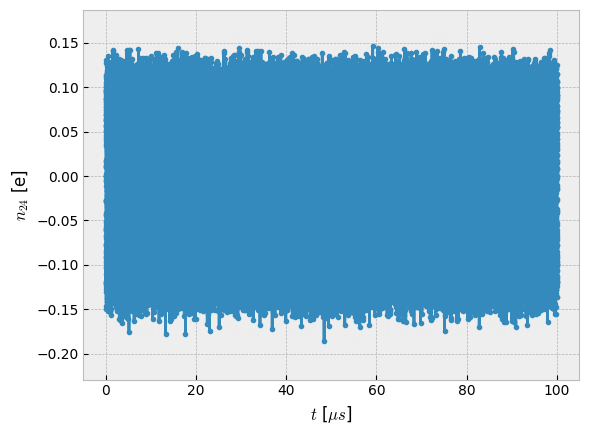

In [12]:
np_index = 24

with plt.style.context("bmh"):

    fig = plt.figure()
    ax  = fig.add_subplot()
    ax.plot(time, microstate[np_index], '.-')
    ax.fill_between(x=time, y1=(microstate[np_index]-microstate_error[np_index]), y2=(microstate[np_index]+microstate_error[np_index]), alpha=0.8)
    ax.set_xlabel("$t$ [$\mu s$]")
    ax.set_ylabel("$n_{"+f"{np_index}"+"}$ [e]")
    # ax.set_xscale('log')
    plt.show()

#### NP Potential

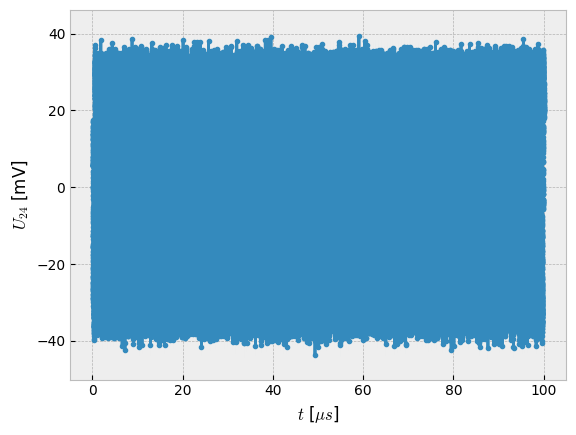

In [17]:
np_index = 24

with plt.style.context("bmh"):

    fig = plt.figure()
    ax  = fig.add_subplot()
    ax.plot(time, landscape[np_index], '.-')
    ax.fill_between(x=time, y1=(landscape[np_index]-landscape_error[np_index]), y2=(landscape[np_index]+landscape_error[np_index]), alpha=0.8)
    ax.set_xlabel("$t$ [$\mu s$]")
    ax.set_ylabel("$U_{"+f"{np_index}"+"}$ [mV]")
    # ax.set_xscale('log')
    plt.show()

### Potential and Jumps Evolution

In [18]:
def return_auto_corr(time, arr, n_lags=20):

    time    = time - np.min(time)
    time    = time[:n_lags]
    a_c     = [1. if t==0 else np.corrcoef(arr[:-t],arr[t:])[0,1] for t in range(n_lags)]

    return time, a_c

def collect_auto_corr(time_evo, arr, t_range, n_stats=50, n_lags=20):

    corr    = pd.DataFrame()

    for i in range(n_stats):

        try:
            t, a_c  = return_auto_corr(time_evo[i], arr[i], n_lags=n_lags)
            func    = interp1d(t, a_c)

            corr[i] = func(t_range)
        except:
            pass
    
    return corr

In [19]:
np_index        = 24
n_run           = 0
stored_indices  = np.where((time_steps >= store_per_it_min) & (time_steps < store_per_it_max))[0]
potential_evo   = [simulation_outputs["network_classes"][n_run].return_pot_per_it()[i][1:,np_index] for i in stored_indices]
time_evo        = [simulation_outputs["network_classes"][n_run].return_time_vals()[i][1:]*10**9 for i in stored_indices]

In [20]:
def jump_diff(np_index, connected_nps):

    abgänge = []

    for i_np in connected_nps:

        jump_index      = np.where(net_currents.columns == (np_index,i_np))[0][0]
        jumps_evo       = [simulation_outputs["network_classes"][n_run].return_jumps_per_it()[i][1:,jump_index] for i in stored_indices]
        jumps_evo       = [np.insert((jumps_evo[i][1:] - jumps_evo[i][0:-1]),0,0) for i in range(len(stored_indices))]
        abgänge.append(jumps_evo)

    zugänge = []

    for i_np in connected_nps:

        jump_index      = np.where(net_currents.columns == (i_np,np_index))[0][0]
        jumps_evo       = [simulation_outputs["network_classes"][n_run].return_jumps_per_it()[i][1:,jump_index] for i in stored_indices]
        jumps_evo       = [np.insert((jumps_evo[i][1:] - jumps_evo[i][0:-1]),0,0) for i in range(len(stored_indices))]
        zugänge.append(jumps_evo)
    
    return np.sum(zugänge,axis=0) - np.sum(abgänge,axis=0)

jump_zu_ab = jump_diff(26, [1,21,25])

/home/jonasmensing/.local/lib/python3.10/site-packages/numpy/core/fromnumeric.py:86: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


In [21]:
t_range_pot     = np.linspace(0,0.15,100)
t_range_jump    = np.linspace(0,0.15,100)
pot_auto_corr   = collect_auto_corr(time_evo, potential_evo, t_range_pot)
jump_auto_corr  = collect_auto_corr(time_evo, jump_zu_ab, t_range_jump)

/home/jonasmensing/.local/lib/python3.10/site-packages/numpy/lib/function_base.py:2845: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
/home/jonasmensing/.local/lib/python3.10/site-packages/numpy/lib/function_base.py:2704: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/home/jonasmensing/.local/lib/python3.10/site-packages/numpy/lib/function_base.py:2704: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
/home/jonasmensing/.local/lib/python3.10/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/jonasmensing/.local/lib/python3.10/site-packages/numpy/core/_methods.py:182: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/home/jonasmensing/.local/lib/python3.10/site-packages/numpy/lib/function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None

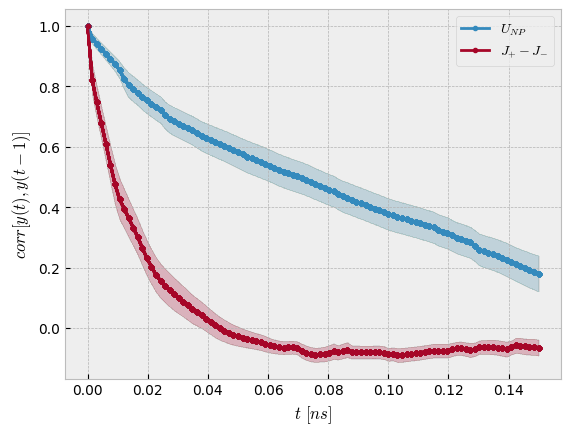

In [22]:
y_pot   = pot_auto_corr.mean(axis=1)
y_jump  = jump_auto_corr.mean(axis=1)

y1_pot  = y_pot - pot_auto_corr.std(axis=1)/np.sqrt(len(pot_auto_corr.columns))
y2_pot  = y_pot + pot_auto_corr.std(axis=1)/np.sqrt(len(pot_auto_corr.columns))

y1_jump = y_jump - jump_auto_corr.std(axis=1)/np.sqrt(len(jump_auto_corr.columns))
y2_jump = y_jump + jump_auto_corr.std(axis=1)/np.sqrt(len(jump_auto_corr.columns))

with plt.style.context("bmh"):
    
    fig = plt.figure()
    ax  = fig.add_subplot()

    for i in range(20):

        ax.plot(t_range_pot, y_pot, '.-', c=blue_color, label='$U_{NP}$')
        ax.fill_between(t_range_pot, y1_pot, y2_pot, color=blue_color, alpha=0.01)

        ax.plot(t_range_jump, y_jump, '.-', c=red_color, label='$J_{+}-J_{-}$')
        ax.fill_between(t_range_jump, y1_jump, y2_jump, color=red_color, alpha=0.01)

        if i == 0:
            ax.legend()

    ax.set_ylabel("$corr[y(t),y(t-1)]$")
    ax.set_xlabel("$t$ $[ns]$")

plt.show()